<a href="https://colab.research.google.com/github/alsh626626/CE888/blob/main/Assignment2/Assignment2_Project2_irony.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 4.4MB/s 
     |████████████████████████████████| 901kB 18.9MB/s 
     |████████████████████████████████| 3.3MB 32.5MB/s 


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import requests
import re
import string
import math
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# Load the data

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

# Experiment focus on hate, irony and offensive
# Both 3 tasks can be run on the same code by alternating the "task" parameter below
# Other tasks have not been tested and may occur errors
task='irony'
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_labels.txt", allow_redirects=True)
open('test_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_text.txt", allow_redirects=True)
open('test_text.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/train_labels.txt", allow_redirects=True)
open('train_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/train_text.txt", allow_redirects=True)
open('train_text.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/val_labels.txt", allow_redirects=True)
open('val_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/val_text.txt", allow_redirects=True)
open('val_text.txt', 'wb').write(r.content)

file = open('test_labels.txt')
test_labels = file.readlines()
file.close
file = open('test_text.txt')
test_text = file.readlines()
file.close
file = open('train_labels.txt')
train_labels = file.readlines()
file.close
file = open('train_text.txt')
train_text = file.readlines()
file.close
file = open('val_labels.txt')
val_labels = file.readlines()
file.close
file = open('val_text.txt')
val_text = file.readlines()
file.close

print("Number of total data:        ", len(train_labels)+len(val_labels)+len(test_labels))
print("Number of train labels:      ", len(train_labels))
print("Number of train text:        ", len(train_text))
print("Number of validation labels: ", len(val_labels))
print("Number of validation text:   ", len(val_text))
print("Number of test labels:       ", len(test_labels))
print("Number of test text:         ", len(test_text))

Number of total data:         4601
Number of train labels:       2862
Number of train text:         2862
Number of validation labels:  955
Number of validation text:    955
Number of test labels:        784
Number of test text:          784


In [ ]:
# Create subset from the dataset for system development
#test_labels = val_labels[:]
#test_text = val_text[:]
#train_labels = train_labels[500:2500]
#train_text = train_text[500:2500]
#val_labels = val_labels[:100]
#val_text = val_text[:100]

In [ ]:
# Download label mapping
import csv
import urllib.request
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
class_labels = [row[1] for row in csvreader if len(row) > 1]
print('Labels:', class_labels)

Labels: ['non_irony', 'irony']


In [ ]:
df = pd.DataFrame(data={'label': train_labels + val_labels + test_labels, 'text': train_text + val_text + test_text})
df

,label,text
0,1\n,seeing ppl walking w/ crutches makes me really...
1,0\n,"look for the girl with the broken smile, ask h..."
2,1\n,Now I remember why I buy books online @user #s...
3,1\n,@user @user So is he banded from wearing the c...
4,1\n,Just found out there are Etch A Sketch apps. ...
...,...,...
4596,0\n,"If you drag yesterday into today, your tomorro..."
4597,0\n,Congrats to my fav @user & her team & my birth...
4598,0\n,@user Jessica sheds tears at her fan signing e...
4599,1\n,#Irony: al jazeera is pro Anti - #GamerGate be...


In [ ]:
df['length'] = df['text'].apply(lambda x: len(word_tokenize(x)))
df

,label,text,length
0,1\n,seeing ppl walking w/ crutches makes me really...,17
1,0\n,"look for the girl with the broken smile, ask h...",25
2,1\n,Now I remember why I buy books online @user #s...,12
3,1\n,@user @user So is he banded from wearing the c...,15
4,1\n,Just found out there are Etch A Sketch apps. ...,14
...,...,...,...
4596,0\n,"If you drag yesterday into today, your tomorro...",27
4597,0\n,Congrats to my fav @user & her team & my birth...,35
4598,0\n,@user Jessica sheds tears at her fan signing e...,18
4599,1\n,#Irony: al jazeera is pro Anti - #GamerGate be...,17


In [ ]:
np.mean(df['length'][:len(train_text)].tolist())

17.360587002096437

  label  counts
0   0\n    2389
1   1\n    2212


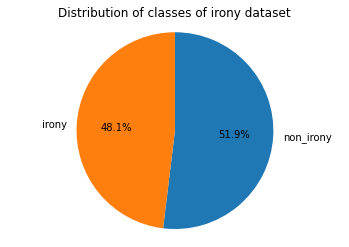

In [ ]:
# Show distribution of classes
df_class = df.groupby('label').size().reset_index(name='counts')
print(df_class)

labels = class_labels
sizes = df_class['counts'].tolist()
plt.title(f"Distribution of classes of {task} dataset")
plt.pie(sizes, labels=labels, autopct='%1.1f%%', counterclock=False, startangle=90)
plt.axis('equal')
plt.show()

# Pre-processing

In [ ]:
# Cleaning the data
df['label'] = df['label'].apply(lambda x: re.sub('\n','', x))
df['text'] = df['text'].apply(lambda x: re.sub('\n','', x))
# Lowercase the words
df['cleaned'] = df['text'].apply(lambda x: x.lower())
# Remove digits and words containing digits
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))
# Remove Punctuations
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
# Remove extra spaces
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
# Remove stop words
stop_words = set(nltk.corpus.stopwords.words("english"))
df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([token for token in list(word_tokenize(x)) if not token in stop_words]))

In [ ]:
%%time
import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stop words removal
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

# Remove stop words again
df['lemmatized'] = df['lemmatized'].apply(lambda x: ' '.join([token for token in list(word_tokenize(x)) if not token in stop_words]))

df

CPU times: user 13min 34s, sys: 6.8 s, total: 13min 41s
Wall time: 13min 43s


# Experiment

In [ ]:
df['lemmatized'] = df['lemmatized'].astype(str)
train_text_list = df['lemmatized'][:len(train_text)].tolist()
val_text_list = df['lemmatized'][len(train_text):len(train_text) + len(val_text)].tolist()
test_text_list = df['lemmatized'][len(train_text) + len(val_text):].tolist()

df['label'] = df['label'].astype(int)
train_label_list = df['label'][:len(train_text)].tolist()
val_label_list = df['label'][len(train_text):len(train_text) + len(val_text)].tolist()
test_label_list = df['label'][len(train_text) + len(val_text):].tolist()

In [ ]:
%%time
# Creating feature vector
# Most frequently 3000 word is selected as the features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=3000)

# Only training set will be used to obtain features
train_set_vector = vectorizer.fit_transform(train_text_list)
val_set_vector = vectorizer.transform(val_text_list)
test_set_vector = vectorizer.transform(test_text_list)

train_set_label = [label for label in train_label_list]
val_set_label = [label for label in val_label_list]
test_set_label = [label for label in test_label_list]

CPU times: user 63 ms, sys: 10 µs, total: 63 ms
Wall time: 69.6 ms


In [ ]:
%%time
# Creating feature tensor
# Most frequently 3000 word is selected as the features
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
max_features = 3000
maxlen = 30
tokenizer = Tokenizer(num_words=3000)

# Only training set will be used to obtain features
tokenizer.fit_on_texts(train_text_list)

train_set_content = tokenizer.texts_to_sequences(train_text_list)
train_set_content = sequence.pad_sequences(train_set_content, maxlen=maxlen)
val_set_content = tokenizer.texts_to_sequences(val_text_list)
val_set_content = sequence.pad_sequences(val_set_content, maxlen=maxlen)
test_set_content = tokenizer.texts_to_sequences(test_text_list)
test_set_content = sequence.pad_sequences(test_set_content, maxlen=maxlen)

CPU times: user 135 ms, sys: 7.04 ms, total: 142 ms
Wall time: 184 ms


In [ ]:
import seaborn as sn
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier

import keras
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Bidirectional, TimeDistributed
from keras.wrappers.scikit_learn import KerasClassifier

# Conventional

In [ ]:
%%time
# Dummy (majority) is used as the classification model
Dummyclf = DummyClassifier(strategy='most_frequent')
# Train Dummy Classifier
Dummyclf = Dummyclf.fit(train_set_vector, train_set_label)

CPU times: user 996 µs, sys: 0 ns, total: 996 µs
Wall time: 1.01 ms


In [ ]:
%%time
# Predict using test dataset
predicted_label = Dummyclf.predict(test_set_vector)

CPU times: user 196 µs, sys: 2 µs, total: 198 µs
Wall time: 224 µs


Majority:
Accuracy Score: 0.39668367346938777
Macro F1 Score: 0.28401826484018267
Clasification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       473
           1       0.40      1.00      0.57       311

    accuracy                           0.40       784
   macro avg       0.20      0.50      0.28       784
weighted avg       0.16      0.40      0.23       784



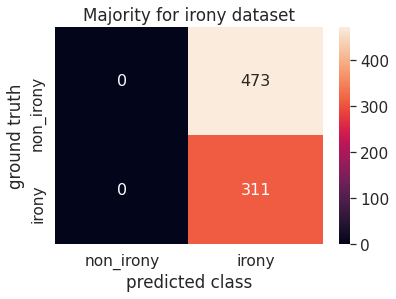

In [ ]:
print("Majority:")
#print('Best parameters: ', Dummyclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label, zero_division=0))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Majority for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Naive Bayes Classifier is used as the classification model
NBclf = MultinomialNB(alpha=1.0, fit_prior=True)
param_grid = {
    # 'fit_prior' : [True, False],
}
NBclf = GridSearchCV(estimator=NBclf, param_grid=param_grid, n_jobs=-1)
# Train Naive Bayes Classifier
NBclf = NBclf.fit(train_set_vector, train_set_label)

CPU times: user 105 ms, sys: 64.8 ms, total: 170 ms
Wall time: 1.13 s


In [ ]:
%%time
# Predict using test dataset
predicted_label = NBclf.predict(test_set_vector)

CPU times: user 630 µs, sys: 0 ns, total: 630 µs
Wall time: 642 µs


Naive Bayes:
Best parameters:  {}
Accuracy Score: 0.6517857142857143
Macro F1 Score: 0.6511676801392514
Clasification report:
               precision    recall  f1-score   support

           0       0.79      0.58      0.67       473
           1       0.54      0.77      0.64       311

    accuracy                           0.65       784
   macro avg       0.67      0.67      0.65       784
weighted avg       0.69      0.65      0.65       784



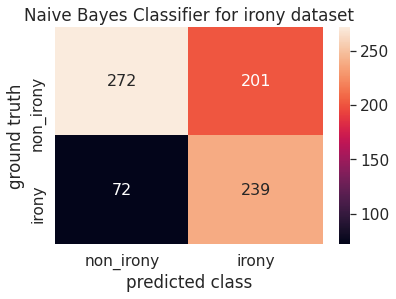

In [ ]:
print("Naive Bayes:")
print('Best parameters: ', NBclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Naive Bayes Classifier for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Decision Tree is used as the classification model
DTclf = DecisionTreeClassifier(criterion="entropy", min_samples_split=10)
param_grid = {
    # 'criterion' : ["entropy", "gini"],
    # 'max_depth' : np.arange(10, 21, 1),
    # 'min_samples_split' : np.arange(10, 21, 1),
}
DTclf = GridSearchCV(estimator=DTclf, param_grid=param_grid, n_jobs=-1)
# Train Decision Tree Classifier
DTclf = DTclf.fit(train_set_vector, train_set_label)

CPU times: user 426 ms, sys: 5.85 ms, total: 432 ms
Wall time: 1.51 s


In [ ]:
%%time
# Predict using test dataset
predicted_label = DTclf.predict(test_set_vector)

CPU times: user 1.38 ms, sys: 897 µs, total: 2.28 ms
Wall time: 4.2 ms


Decision Tree:
Best parameters:  {}
Accuracy Score: 0.6198979591836735
Macro F1 Score: 0.6050524721410797
Clasification report:
               precision    recall  f1-score   support

           0       0.69      0.67      0.68       473
           1       0.52      0.54      0.53       311

    accuracy                           0.62       784
   macro avg       0.60      0.61      0.61       784
weighted avg       0.62      0.62      0.62       784



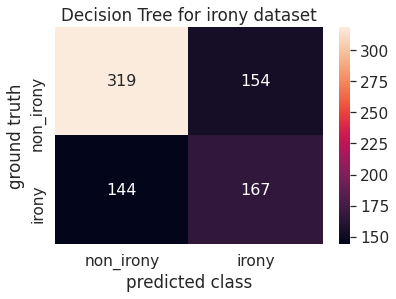

In [ ]:
print("Decision Tree:")
print('Best parameters: ', DTclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Decision Tree for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# K-Nearest Neighbors is used as the classification model
KNNclf = KNeighborsClassifier(weights="distance", p = 2, n_neighbors=5) #euclidean distance
param_grid = {
        #'n_neighbors': np.arange(1, 11, 1),
        #'weights': ["uniform", "distance"],
}
KNNclf = GridSearchCV(estimator=KNNclf, param_grid=param_grid, n_jobs=-1)
# Train K-Nearest Neighbors Classifier
KNNclf = KNNclf.fit(train_set_vector, train_set_label)

CPU times: user 70 ms, sys: 1.01 ms, total: 71 ms
Wall time: 220 ms


In [ ]:
%%time
# Predict using test dataset
predicted_label = KNNclf.predict(test_set_vector)

CPU times: user 59.3 ms, sys: 21 ms, total: 80.3 ms
Wall time: 87.9 ms


K-Nearest Neighbors:
Best parameters:  {}
Accuracy Score: 0.5637755102040817
Macro F1 Score: 0.5568513119533528
Clasification report:
               precision    recall  f1-score   support

           0       0.66      0.57      0.61       473
           1       0.46      0.55      0.50       311

    accuracy                           0.56       784
   macro avg       0.56      0.56      0.56       784
weighted avg       0.58      0.56      0.57       784



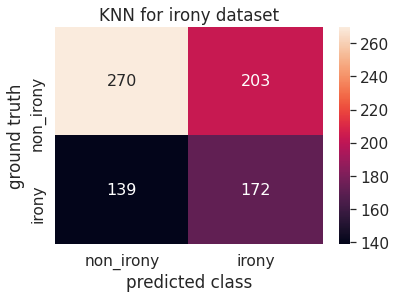

In [ ]:
print("K-Nearest Neighbors:")
print('Best parameters: ', KNNclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"KNN for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Support Vector Machine is used as the classification model
SVMclf = SVC(kernel='rbf', C=1, gamma=0.1)
param_grid = {
    #'kernel': ["linear", "poly", "rbf"],
    #'C' : np.logspace(-1, 3, 5),
    #'gamma' : np.logspace(-4, -0, 5),
}
SVMclf = GridSearchCV(estimator=SVMclf, param_grid=param_grid, n_jobs=-1)
# Train Support Vector Machine Classifier
SVMclf = SVMclf.fit(train_set_vector, train_set_label)

CPU times: user 770 ms, sys: 7.02 ms, total: 777 ms
Wall time: 2.82 s


In [ ]:
%%time
# Predict using test dataset
predicted_label = SVMclf.predict(test_set_vector)

CPU times: user 157 ms, sys: 2.97 ms, total: 160 ms
Wall time: 160 ms


Support Vector Machine:
Best parameters:  {}
Accuracy Score: 0.6811224489795918
Macro F1 Score: 0.667264232942199
Clasification report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74       473
           1       0.60      0.60      0.60       311

    accuracy                           0.68       784
   macro avg       0.67      0.67      0.67       784
weighted avg       0.68      0.68      0.68       784



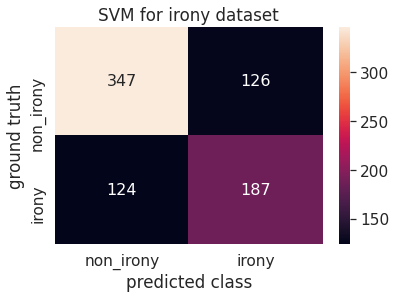

In [ ]:
print("Support Vector Machine:")
print('Best parameters: ', SVMclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"SVM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

# Deep Learning

In [ ]:
%%time
# SimpleANN is used as the classification model
model = models.Sequential()
model.add(Dense(32, input_shape=(30,)))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train SimpleANN Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
23/23 [==============================] - 1s 17ms/step - loss: 75.2118 - acc: 0.5245 - val_loss: 14.8859 - val_acc: 0.4806
Epoch 2/5
23/23 [==============================] - 0s 6ms/step - loss: 11.8341 - acc: 0.4898 - val_loss: 2.4706 - val_acc: 0.4974
Epoch 3/5
23/23 [==============================] - 0s 5ms/step - loss: 5.8983 - acc: 0.5177 - val_loss: 5.9048 - val_acc: 0.4806
Epoch 4/5
23/23 [==============================] - 0s 6ms/step - loss: 5.5581 - acc: 0.5239 - val_loss: 3.1213 - val_acc: 0.4

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 125 ms, sys: 2.06 ms, total: 127 ms
Wall time: 134 ms


SimpleANN:
Accuracy Score: 0.6007653061224489
Macro F1 Score: 0.3812092282010354
Clasification report:
               precision    recall  f1-score   support

           0       0.60      0.99      0.75       473
           1       0.33      0.01      0.01       311

    accuracy                           0.60       784
   macro avg       0.47      0.50      0.38       784
weighted avg       0.50      0.60      0.46       784



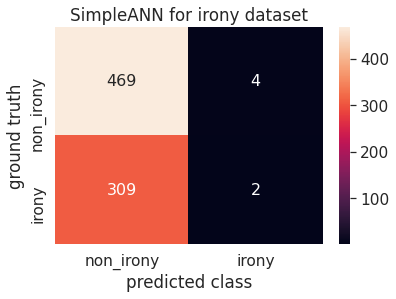

In [ ]:
print("SimpleANN:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"SimpleANN for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# SimpleRNN is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train SimpleRNN Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          96000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 98,113
Trainable params: 98,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
23/23 [==============================] - 2s 29ms/step - loss: 0.6950 - acc: 0.5168 - val_loss: 0.6901 - val_acc: 0.5340
Epoch 2/5
23/23 [==============================] - 0s 17ms/step - loss: 0.6523 - acc: 0.6987 - val_loss: 0.6796 - val_

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 252 ms, sys: 7.02 ms, total: 259 ms
Wall time: 231 ms


SimpleRNN:
Accuracy Score: 0.5727040816326531
Macro F1 Score: 0.5727033864525628
Clasification report:
               precision    recall  f1-score   support

           0       0.72      0.47      0.57       473
           1       0.47      0.72      0.57       311

    accuracy                           0.57       784
   macro avg       0.60      0.60      0.57       784
weighted avg       0.62      0.57      0.57       784



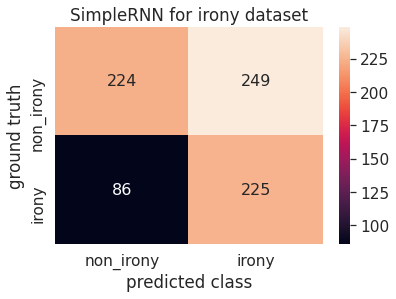

In [ ]:
print("SimpleRNN:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"SimpleRNN for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# LSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train LSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
23/23 [==============================] - 4s 55ms/step - loss: 0.6918 - acc: 0.5259 - val_loss: 0.6877 - val_acc: 0.5738
Epoch 2/5
23/23 [==============================] - 1s 28ms/step - loss: 0.6763 - acc: 0.6680 - val_loss: 0.6727 - va

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 545 ms, sys: 15.1 ms, total: 560 ms
Wall time: 514 ms


LSTM:
Accuracy Score: 0.6875
Macro F1 Score: 0.6492170022371364
Clasification report:
               precision    recall  f1-score   support

           0       0.70      0.84      0.77       473
           1       0.65      0.45      0.53       311

    accuracy                           0.69       784
   macro avg       0.68      0.65      0.65       784
weighted avg       0.68      0.69      0.67       784



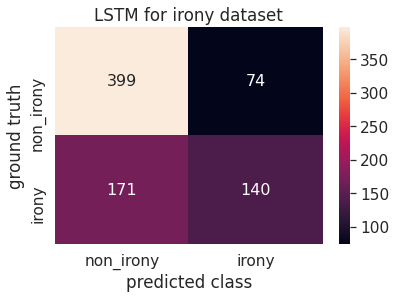

In [ ]:
print("LSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"LSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# BiLSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train BiLSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 112,705
Trainable params: 112,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
23/23 [==============================] - 5s 83ms/step - loss: 0.6923 - acc: 0.5178 - val_loss: 0.6888 - val_acc: 0.5728
Epoch 2/5
23/23 [==============================] - 1s 43ms/step - loss: 0.6787 - acc: 0.6526 - val_loss: 0.6836 - va

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 943 ms, sys: 25.7 ms, total: 969 ms
Wall time: 858 ms


BiLSTM:
Accuracy Score: 0.6951530612244898
Macro F1 Score: 0.6615605250276801
Clasification report:
               precision    recall  f1-score   support

           0       0.71      0.84      0.77       473
           1       0.66      0.48      0.55       311

    accuracy                           0.70       784
   macro avg       0.68      0.66      0.66       784
weighted avg       0.69      0.70      0.68       784



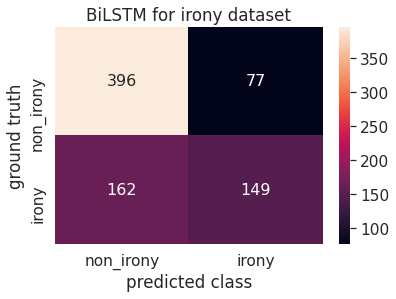

In [ ]:
print("BiLSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"BiLSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Hierarchical LSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train Hierarchical LSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 120,993
Trainable params: 120,993
Non-trainable params: 0
________________________________________________

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 1.55 s, sys: 32 ms, total: 1.58 s
Wall time: 1.45 s


Hierarchical LSTM:
Accuracy Score: 0.6045918367346939
Macro F1 Score: 0.6021034295331461
Clasification report:
               precision    recall  f1-score   support

           0       0.72      0.57      0.63       473
           1       0.50      0.66      0.57       311

    accuracy                           0.60       784
   macro avg       0.61      0.61      0.60       784
weighted avg       0.63      0.60      0.61       784



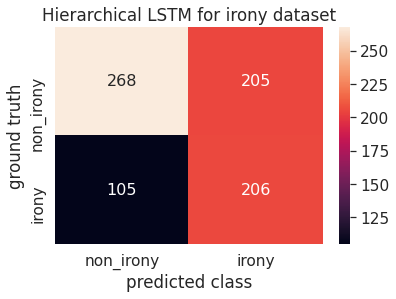

In [ ]:
print("Hierarchical LSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Hierarchical LSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Hierarchical BiLSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train Hierarchical BiLSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          16640     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 162,369
Trainable params: 162,369
Non-trainable params: 0
________________________________________________

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 2.71 s, sys: 63.1 ms, total: 2.77 s
Wall time: 2.41 s


Hierarchical BiLSTM:
Accuracy Score: 0.6505102040816326
Macro F1 Score: 0.6429611408436658
Clasification report:
               precision    recall  f1-score   support

           0       0.73      0.66      0.69       473
           1       0.55      0.64      0.59       311

    accuracy                           0.65       784
   macro avg       0.64      0.65      0.64       784
weighted avg       0.66      0.65      0.65       784



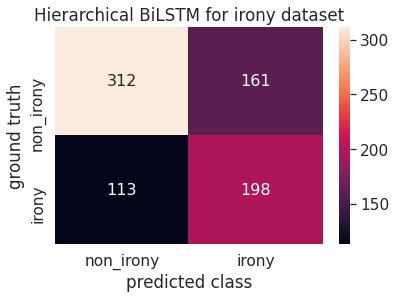

In [ ]:
print("Hierarchical BiLSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Hierarchical BiLSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# BiGRU is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(GRU(32)))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train BiGRU Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                12672     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 108,737
Trainable params: 108,737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
23/23 [==============================] - 6s 78ms/step - loss: 0.6917 - acc: 0.5235 - val_loss: 0.6869 - val_acc: 0.5895
Epoch 2/5
23/23 [==============================] - 1s 39ms/step - loss: 0.6732 - acc: 0.6443 - val_loss: 0.6731 - va

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 858 ms, sys: 10 ms, total: 868 ms
Wall time: 756 ms


BiGRU:
Accuracy Score: 0.6721938775510204
Macro F1 Score: 0.6605837633142473
Clasification report:
               precision    recall  f1-score   support

           0       0.74      0.71      0.72       473
           1       0.58      0.61      0.60       311

    accuracy                           0.67       784
   macro avg       0.66      0.66      0.66       784
weighted avg       0.68      0.67      0.67       784



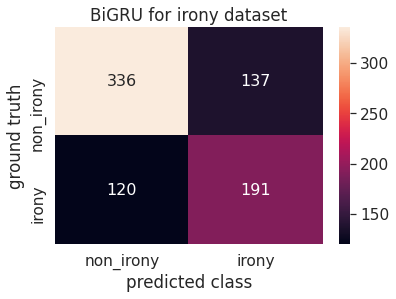

In [ ]:
print("BiGRU:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"BiGRU for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = [
    ]
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
%%time
# RoBERTa is used as the classification model
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)

#golden_label = [i[1] for i in test_set]
tested_label = []
for i in range(len(test_text)):
  text = test_text[i]
  text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  tested_label.append(np.argmax(scores))


CPU times: user 2min 7s, sys: 3.12 s, total: 2min 11s
Wall time: 2min 12s


RoBERTa:
Accuracy Score: 0.6964285714285714
Macro F1 Score: 0.6810785681078568
Clasification report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75       473
           1       0.62      0.60      0.61       311

    accuracy                           0.70       784
   macro avg       0.68      0.68      0.68       784
weighted avg       0.69      0.70      0.70       784



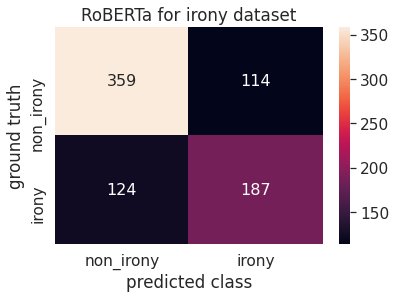

In [ ]:
print("RoBERTa:")
accuracy = metrics.accuracy_score(test_set_label, tested_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, tested_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, tested_label))

cm = confusion_matrix(test_set_label, tested_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"RoBERTa for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()